## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

dqn3.ipynb의 코드에서 좀 더 파이토치 튜토리얼과 코드를 섞은 버전

In [40]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
import math
import itertools
from tqdm import tqdm

In [41]:
Transition = collections.namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = collections.deque([], maxlen=capacity)

    def append(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [42]:
env = gymnasium.make('CartPole-v1')
hidden_size = 128
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(n_observations, 128)
        self.layer2 = torch.nn.Linear(128, 128)
        self.layer3 = torch.nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = torch.nn.functional.relu(self.layer2(x))
        return self.layer3(x)
q = DQN(*env.observation_space.shape, env.action_space.n)
target_q = DQN(*env.observation_space.shape, env.action_space.n)
target_q.load_state_dict(q.state_dict())
# target_q = copy.deepcopy(q).requires_grad_(False)

<All keys matched successfully>

In [43]:
lr = 1e-4
discount = 0.99
criterion = torch.nn.HuberLoss()
optimizer = torch.optim.AdamW(q.parameters(), lr=lr, amsgrad=True)
replay_buffer = ReplayMemory(10000)
num_episodes = 600
batch_size = 128
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005

In [44]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end) * \
        math.exp(-1. * steps_done / eps_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return q(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device='cpu', dtype=torch.long)


In [45]:
def optimize_model():
    if len(replay_buffer) < batch_size:
        return
    transitions = replay_buffer.sample(batch_size)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device='cpu', dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = q(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(batch_size, device='cpu')
    with torch.no_grad():
        next_state_values[non_final_mask] = target_q(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * discount) + reward_batch
    criterion = torch.nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(q.parameters(), 100)
    optimizer.step()

In [46]:
steps = []
device = 'cpu'
for i in tqdm(range(num_episodes)):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device='cpu').unsqueeze(0)
    for step in itertools.count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        replay_buffer.append(state, action, next_state, reward)
    
        optimize_model()
            
        target_q_state_dict = target_q.state_dict()
        q_state_dict = q.state_dict() 
        for key in q_state_dict:
            target_q_state_dict[key] = tau * q_state_dict[key] + (1-tau) * target_q_state_dict[key]
        target_q.load_state_dict(target_q_state_dict)
            
        state = next_state
        if terminated or truncated:
            break
    
    steps.append(step)

    if (i + 1) % 100 == 0:
        print(np.mean(steps[-100:]))

 17%|█▋        | 101/600 [00:04<00:24, 20.48it/s]

13.5


 33%|███▎      | 200/600 [00:36<03:10,  2.10it/s]

86.78


 50%|█████     | 300/600 [01:33<02:06,  2.37it/s]

134.51


 67%|██████▋   | 400/600 [02:00<00:53,  3.77it/s]

62.93


 83%|████████▎ | 499/600 [02:20<00:16,  6.05it/s]

48.09


100%|██████████| 600/600 [02:58<00:00,  3.36it/s]

70.6


In [47]:
len(replay_buffer)

10000

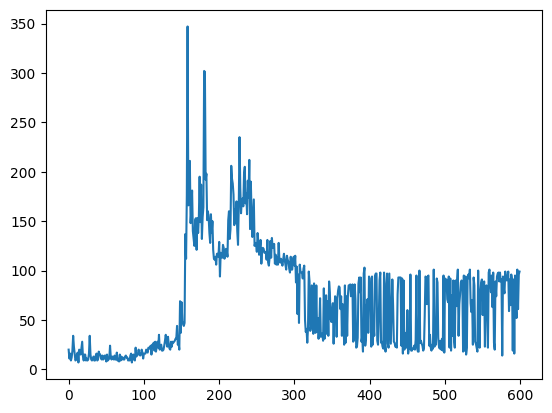

In [48]:
import matplotlib.pyplot as plt
plt.plot(steps)

In [49]:
env = gymnasium.make('CartPole-v1', render_mode='human')
scores = []
for i in range(10):
    score = 0
    state, info = env.reset()
    while True:
        action = torch.argmax(target_q(torch.tensor(state))).cpu().detach().item()
        next_state, reward, terminated, truncated, info = env.step(action)
        score += reward
        state = next_state
        if terminated or truncated:
            break
    scores.append(score)
env.close()
scores

[88.0, 100.0, 91.0, 91.0, 90.0, 96.0, 97.0, 91.0, 59.0, 92.0]

In [50]:
env.close()

In [51]:
env = gymnasium.make('CartPole-v1')